In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fastjet as fj


In [11]:
# Generate mock particles
particles = []
#n_jets = np.random.randint(5, 15)
n_jets = 5
eta_values_list = []
phi_values_list = []
energy_values_list = []
print(n_jets)

5


In [12]:
for nj in range(n_jets):
    phi_0 = np.random.uniform(-np.pi, np.pi)
    eta_0 = np.random.uniform(-3, 3)
    Nj = np.random.randint(5, 15)
    eta_values = []
    phi_values = []
    energy_values = []
    for n_part in range(Nj):
        E = np.random.exponential(4)
        eta = np.random.normal(eta_0, 0.4)
        phi = np.random.normal(phi_0, 0.4)
        px = E * np.cos(phi)
        py = E * np.sin(phi)
        pz = E * np.sinh(eta)
        particles.append(fj.PseudoJet(px, py, pz, E))
        eta_values.append(eta)
        phi_values.append(phi)
        energy_values.append(E)
    
    eta_values_list.append(eta_values)
    phi_values_list.append(phi_values)
    energy_values_list.append(energy_values)

# Convert particle data to numpy array for clustering
#particle_data = np.array([[p.eta(), p.phi(), p.pt(), p.e()] for p in particles])
particle_data = np.array([[p.eta(), p.phi(), p.pt(), p.e(), p.px(), p.py(), p.pz()] for p in particles])


In [13]:
# Custom anti-kt algorithm
def delta_r(p1, p2):
    delta_eta = p1[0] - p2[0]
    delta_phi = np.abs(p1[1] - p2[1])
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def anti_kt_algorithm(data, R, target_clusters):
    n_particles = data.shape[0]
    pt = data[:, 2]
    distances = np.zeros((n_particles, n_particles))
    
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            distances[i, j] = delta_r(data[i], data[j])
            distances[j, i] = distances[i, j]
    
    clusters = np.arange(n_particles)
    active = np.ones(n_particles, dtype=bool)
    p4_values = {i: [data[i, 4:8]] for i in range(n_particles)}

    while np.sum(active) > target_clusters:
        min_dist = np.inf
        merge_pair = (-1, -1)
        
        for i in range(n_particles):
            if not active[i]:
                continue
            for j in range(i + 1, n_particles):
                if not active[j]:
                    continue
                dist_ij = min(pt[i]**-2, pt[j]**-2) * (distances[i, j]**2 / R**2)
                if dist_ij < min_dist:
                    min_dist = dist_ij
                    merge_pair = (i, j)
                    active[j] = False
                    clusters[j] = clusters[i]
        
        for i in range(n_particles):
            if not active[i]:
                continue
            dist_iB = pt[i]**-2
            if dist_iB < min_dist:
                min_dist = dist_iB
                merge_pair = (i, -1)
        
        if merge_pair[1] == -1:
            active[merge_pair[0]] = False
        else:
            pt_sum = pt[merge_pair[0]] + pt[merge_pair[1]]
            eta_sum = (pt[merge_pair[0]] * data[merge_pair[0], 0] + pt[merge_pair[1]] * data[merge_pair[1], 0]) / pt_sum
            phi_sum = (pt[merge_pair[0]] * data[merge_pair[0], 1] + pt[merge_pair[1]] * data[merge_pair[1], 1]) / pt_sum
            data[merge_pair[0], 0] = eta_sum
            data[merge_pair[0], 1] = phi_sum
            data[merge_pair[0], 2] = pt_sum
            active[merge_pair[1]] = False
            clusters[merge_pair[1]] = merge_pair[0]
            
            p4_values[merge_pair[0]].extend(p4_values[merge_pair[1]])
            p4_values[merge_pair[1]] = []
    
    return clusters, p4_values
    
R = 0.4

In [14]:
# FastJet anti-kt algorithm
jet_algorithm = fj.JetDefinition(fj.antikt_algorithm, R)
cluster_sequence = fj.ClusterSequence(particles, jet_algorithm)
fastjet_clusters = cluster_sequence.inclusive_jets(ptmin=0.0)

In [15]:
# Run the custom anti-kt algorithm with the target number of clusters

target_clusters = len(fastjet_clusters)
custom_clusters, custom_p4_values = anti_kt_algorithm(particle_data[:, :], R, target_clusters)
unique_custom_clusters = np.unique(custom_clusters)

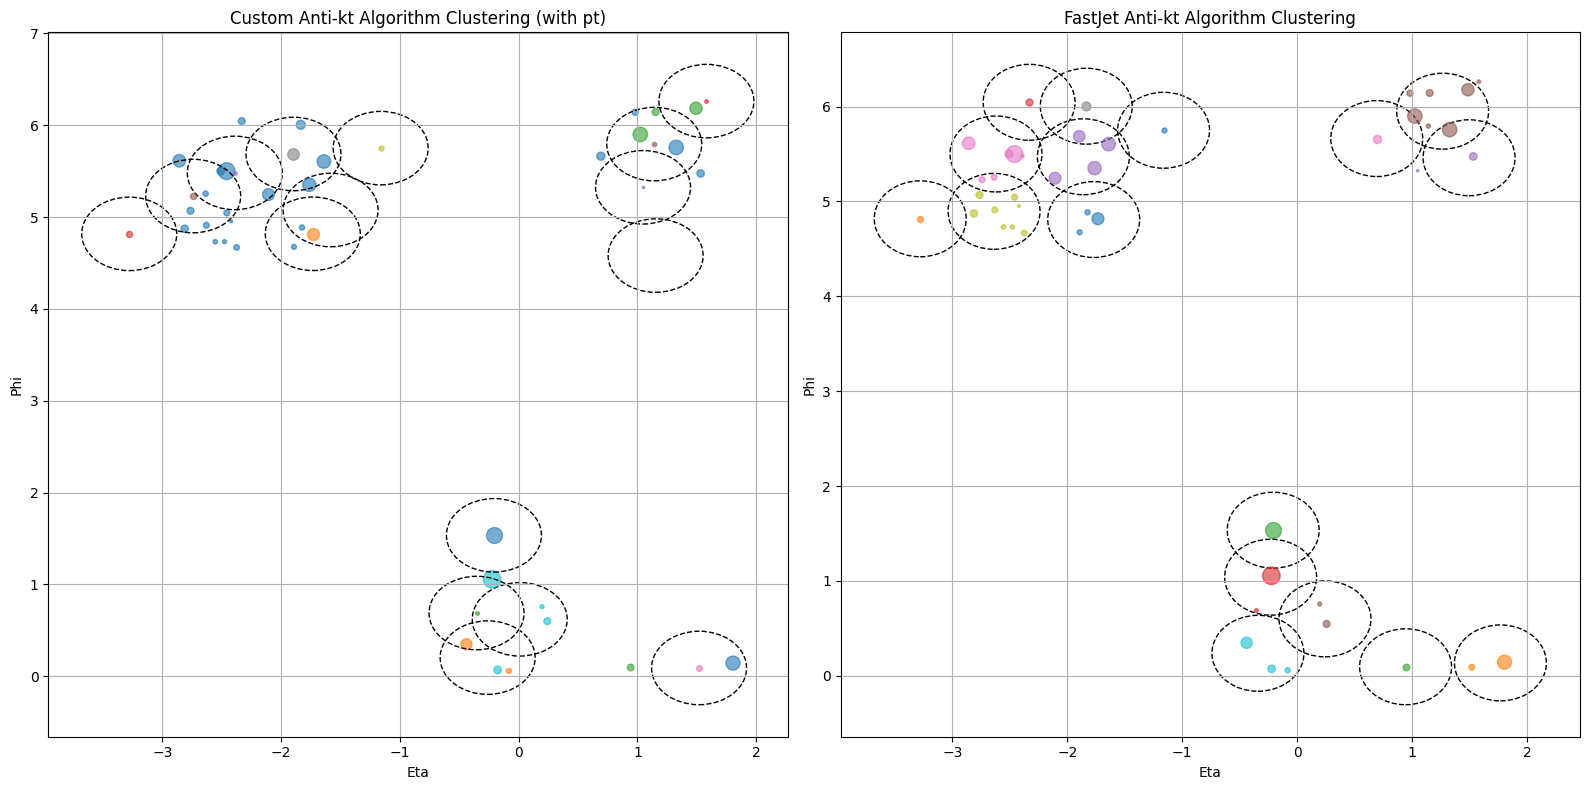

In [16]:
# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the particles with custom Cambridge algorithm clusters
ax = axes[0]
for cluster in unique_custom_clusters:
    cluster_indices = np.where(custom_clusters == cluster)[0]
    eta_values = particle_data[cluster_indices, 0]
    phi_values = particle_data[cluster_indices, 1]
    energy_values = particle_data[cluster_indices, 3]
    eta_center = np.mean(eta_values)
    phi_center = np.mean(phi_values)
    circle = plt.Circle((eta_center, phi_center), R, fill=False, linestyle="--")
    ax.add_patch(circle)
    ax.scatter(eta_values, phi_values, s=energy_values * 10, alpha=0.6, label=f'Cluster {cluster}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('Custom Anti-kt Algorithm Clustering (with pt)')
ax.grid(True)

# Plot the particles with FastJet Cambridge/Aachen algorithm clusters
ax = axes[1]
for jet in fastjet_clusters:
    constituents = jet.constituents()
    eta_values = [p.eta() for p in constituents]
    phi_values = [p.phi() for p in constituents]
    energy_values = [p.e() for p in constituents]
    circle = plt.Circle((jet.eta(), jet.phi()), R, fill=False, linestyle="--")
    ax.add_patch(circle)
    ax.scatter(eta_values, phi_values, s=np.array(energy_values) * 10, alpha=0.6, label=f'Jet with pT={jet.pt():.2f}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('FastJet Anti-kt Algorithm Clustering')
ax.grid(True)

plt.tight_layout()
plt.show()

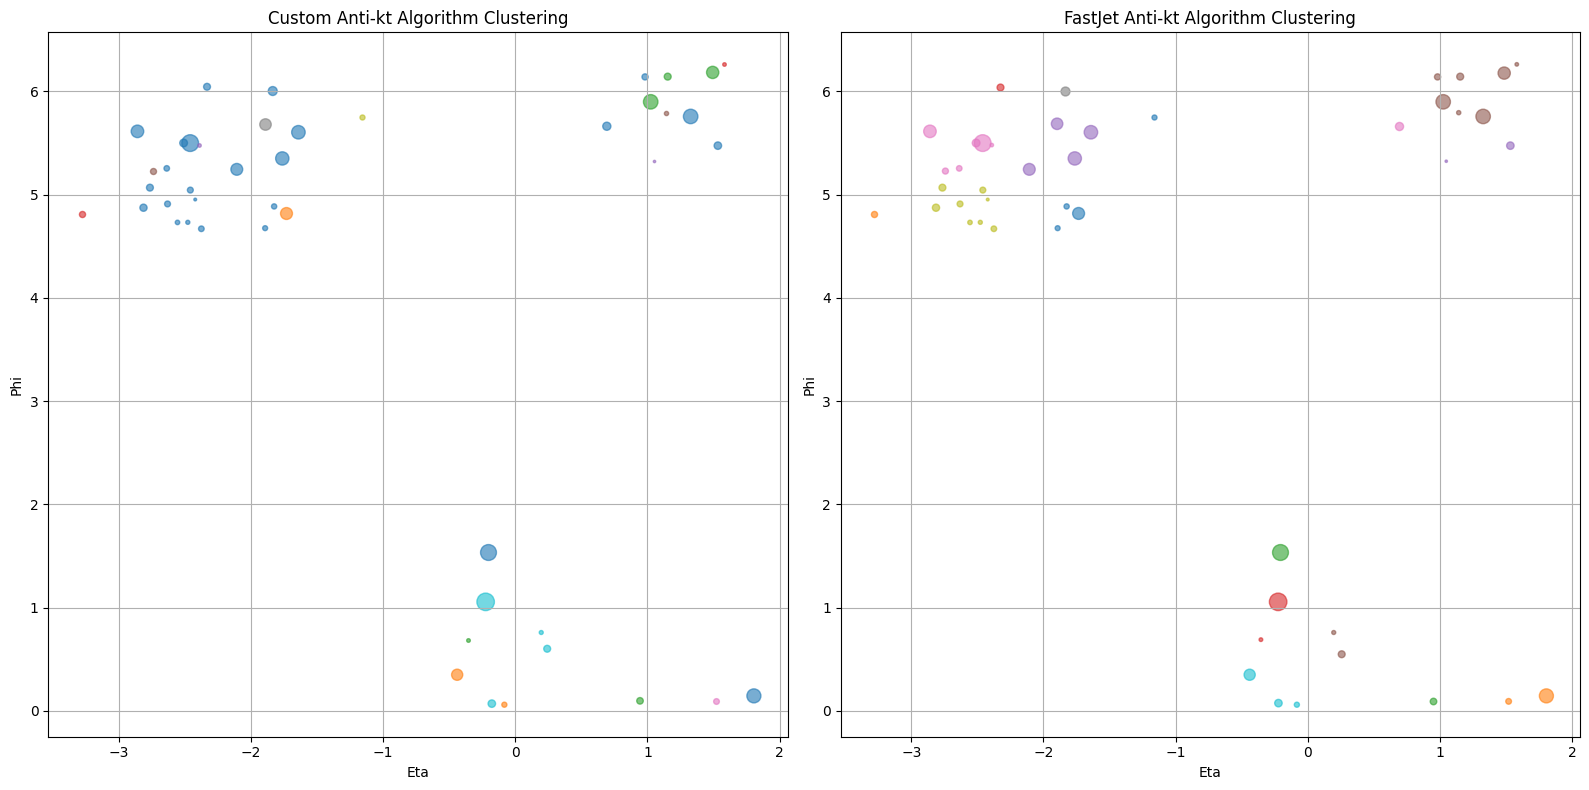

In [17]:
# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the particles with custom anti-kt algorithm clusters
ax = axes[0]
for cluster in unique_custom_clusters:
    cluster_indices = np.where(custom_clusters == cluster)[0]
    eta_values = particle_data[cluster_indices, 0]
    phi_values = particle_data[cluster_indices, 1]
    energy_values = particle_data[cluster_indices, 3]
    ax.scatter(eta_values, phi_values, s=energy_values * 10, alpha=0.6, label=f'Cluster {cluster}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('Custom Anti-kt Algorithm Clustering')
ax.grid(True)

# Plot the particles with FastJet anti-kt algorithm clusters
ax = axes[1]
for jet in fastjet_clusters:
    constituents = jet.constituents()
    eta_values = [p.eta() for p in constituents]
    phi_values = [p.phi() for p in constituents]
    energy_values = [p.e() for p in constituents]
    ax.scatter(eta_values, phi_values, s=np.array(energy_values) * 10, alpha=0.6, label=f'Jet with pT={jet.pt():.2f}')
ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title('FastJet Anti-kt Algorithm Clustering')
ax.grid(True)

plt.tight_layout()
plt.show()

In [18]:
len(fastjet_clusters)

17

In [20]:
len(unique_custom_clusters)

16